In [1]:
'''
见书本attention章图解
attention中分为三大快     encode,decode
input = [['ich mochte ein bier P'],[].....]   (m,b,v)
output =[['S i want a beer'], [],[]......]   (m,b,v)
target = [['i want a beer E'],[],[]......]   (m,b)

随机初始化最开始的hidden (1,b,h)
input和hidden运行RNN操作
enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)    #self.enc_cell( (m,b,v),(1,b,h) )
# enc_outputs :(m,b,h)   enc_hidden: (1,b,h)

enc_hidden作为新的hidden ， 和output每一层进行RNN操作（迭代m次）：
for i in range(m): 
            # 得到dec_output:(1,b,h) 和新的hidden：(1,b,h)
            dec_output, hidden = self.dec_cell( dec_inputs[i], hidden)      # self.dec_cell(   (b,v), ( 1,b,h )  )
            
            # 用dec_output:(b,h)和enc_output(m,b,h)中的每一层(b,h)内积和操作得到m层(1,b),即(m,1,b),然后softmax操作得attention=(m,1,b)  
            attn_weights = self.get_att_weight(dec_output, enc_outputs)   #self.get_att_weight(  (1,b,h), (m,b,h) )      
            
            #attention：(b,m,1)和enc_outputs :(b,m,h) 运行bmm（batch  matrix multip)操作得到context=(b,1,h)  
            #                                          <=============>  等效于每一层enc_output和其attention的乘积，然后相加
            context = attn_weights.bmm(enc_outputs)
            
            #context：(b,1,h) 和这一层的dec_output:(1,b,h)运行concat操作得到(b,2h)
            #(v,2h)*(b,2h) =(v,b)
output的每一层/每一次迭代得到一个(v,b)，m次后得到(v,b,m)
(v,b,m)和target:(m,b)运行交叉熵得到loss，反向传播


test操作：
input = ['ich mochte ein bier P']      
output =['S P P P P P']
求target是否等于['i want a beer E'],

'''

'\nn_class=v=11   h=n_hidden=128   b=1   max_len=m=5\ndkfjd \n'

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

dtype = torch.FloatTensor
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)  # vocab list




print(' word_list=',word_list)
print(' number_dict=',number_dict)
print(' n_class=',n_class)


 word_list= ['i', 'beer', 'E', 'a', 'ein', 'S', 'P', 'want', 'ich', 'bier', 'mochte']
 number_dict= {0: 'i', 1: 'beer', 2: 'E', 3: 'a', 4: 'ein', 5: 'S', 6: 'P', 7: 'want', 8: 'ich', 9: 'bier', 10: 'mochte'}
 n_class= 11


In [3]:
def make_batch(sentences):
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]      #(b,m,v)= (1,5,11)
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]      #(b,m,v)= (1,5,11)
    target_batch = [[word_dict[n] for n in sentences[2].split()]]                       #(b,m)=(1,5)
    # make tensor
    return Variable(torch.Tensor(input_batch)), Variable(torch.Tensor(output_batch)), Variable(torch.LongTensor(target_batch))

input_batch, output_batch, target_batch = make_batch(sentences)

In [4]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)  #(v,h)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)  #(v,h)
 
        # Linear for attention
        self.attn = nn.Linear(n_hidden, n_hidden)   #(h,h)
        self.out = nn.Linear(n_hidden * 2, n_class) #(2h,v)

    def forward(self, enc_inputs, hidden, dec_inputs):         #model(  (b,m,v),(1,b,h),(b,m,v)   )
        enc_inputs = enc_inputs.transpose(0, 1)  # enc_inputs: (m,b,v) 
        dec_inputs = dec_inputs.transpose(0, 1)  # dec_inputs: (m,b,v) 

        # enc_outputs : [m, b, num_directions(=1) * h]            =(m,b,h)=(5,1,h)           matrix F
        # enc_hidden : [num_layers(=1) * num_directions(=1), b, h]=(1,b,h)
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)  #self.enc_cell( (m,b,v),(1,b,h) )

        trained_attn = []
        hidden = enc_hidden #(1,b,h)=(1,1,h)
        # dec_inputs.size()   =  torch.Size([5, 1, 11]) =(m,b,v)
        n_step = len(dec_inputs)            #n_step=m=5

        model = Variable(torch.empty([n_step, 1, n_class]))      #(m,b,v)=(5,1,v)

        for i in range(n_step):  # each time step
            # dec_output : [m(=1), b(=1), num_directions(=1) * h] =(m,b,h) =(1,1,h)
            # hidden : [num_layers(=1) * num_directions(=1), b(=1), h] = (1,b,h) = (1,1,h)
            dec_output, hidden = self.dec_cell(dec_inputs[i].unsqueeze(0), hidden)       # self.dec_cell(   (b,v), ( 1,b,h )  )
            
            # attn_weights : [b,1,m]=(1,1,m)
            attn_weights = self.get_att_weight(dec_output, enc_outputs)   #self.get_att_weight(  (1,b,h), (5,1,h)          )      
                # print(attn_weights.squeeze())                            #tensor([ 0.1914,  0.2034,  0.2043,  0.1994,  0.2016])
                # print(attn_weights.squeeze().data.numpy())               #[0.19141854 0.20338222 0.20427436 0.19936943 0.20155545]
            trained_attn.append(attn_weights.squeeze().data.numpy())

            # matrix-matrix product of matrices [b,1,m] x [b,m,h] =(b,1,h)=(1,1,m)x (1,m,h) = (1,1,h)
            context = attn_weights.bmm(enc_outputs.transpose(0, 1))
            dec_output = dec_output.squeeze(0)      # (1,b,h) ===>(b,h)
            context = context.squeeze(1)            # (b,1,h)===>(b,h)
            model[i] = self.out(torch.cat((dec_output, context), 1))  #(2h,v) *(2h,b) =(v,b)
        # model.size() =(m,b,v)= torch.Size([5, 1, 11])
        # model.transpose(0,1).squeeze(0).size()       #(m,b,v)=====>(b,m,v)====>(b*m,v)
        return model.transpose(0, 1).squeeze(0), trained_attn

    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs)
        attn_scores = Variable(torch.zeros(n_step))  # attn_scores : [n_step]

        for i in range(n_step):
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores).view(1, 1, -1)

    def get_att_score(self, dec_output, enc_output):  # enc_outputs=dec_output=  [b, num_directions(=1) * h]=(h,b)
        score = self.attn(enc_output)  # score : (h,b)*(h,b)= (h,b)
        return torch.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar value# Parameter
    


In [5]:
# Parameter
n_hidden = 128

# hidden : [num_layers(=1) * num_directions(=1), b, h]=(1,b,h)
hidden = Variable(torch.zeros(1, 1, n_hidden))

model = Attention()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train
for epoch in range(2000):
    optimizer.zero_grad()
    output, _ = model(input_batch, hidden, output_batch)       #model(  (b,m,v),(1,b,h),(b,m,v)   )     output:(b*m,v)

    loss = criterion(output, target_batch.squeeze(0))     # target_batch:(b,m)=>(b*m)
    if (epoch + 1) % 400 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()


C:\software_installed_cs\Anaconda3\envs\pytorch0.4\lib\site-packages\torch\nn\modules\rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
C:\software_installed_cs\Anaconda3\envs\pytorch0.4\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0400 cost = 0.000501


Epoch: 0800 cost = 0.000161


Epoch: 1200 cost = 0.000079


Epoch: 1600 cost = 0.000046


Epoch: 2000 cost = 0.000030


ich mochte ein bier P =========> ['i', 'want', 'a', 'beer', 'E']


C:\software_installed_cs\Anaconda3\envs\pytorch0.4\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


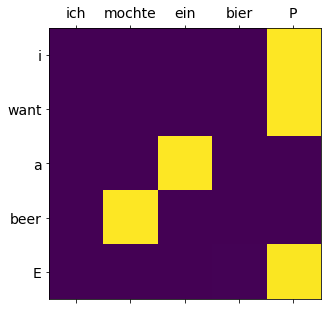

In [7]:
# Test
# sentences = ['ich mochte ein bier P', 'S P P P P']
test_batch = [np.eye(n_class)[[word_dict[n] for n in 'SPPPP']]]  #(b,m,v)=(1,5,v)
test_batch = Variable(torch.Tensor(test_batch))
predict, trained_attn = model(input_batch, hidden, test_batch)
predict = predict.data.max(1, keepdim=True)[1]
print(sentences[0], '=========>', [number_dict[n.item()] for n in predict.squeeze()])



# Show Attention
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(trained_attn, cmap='viridis')
ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
plt.show()